In [1]:
%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(1, '../')

import matplotlib.pyplot as plt
from os import path

from deployment_instance import ExperimentResult
from src.ingest_data import ingest_experiment_results
from src.query_data import get_data_exfiltration_times, get_data_exfiltration_cdf
from statistics import mean
import seaborn as sns

import pandas as pd

In [2]:
# Baseline attacker
bfs_layered_d10_h50 = ingest_experiment_results(path.join('data/Layered/ICS/bfs_layered_d10_h50'))
dfs_layered_d10_h50 = ingest_experiment_results(path.join('data/Layered/ICS/dfs_layered_d10_h50'))
targeted_layered_d10_h50 = ingest_experiment_results(path.join('data/Layered/ICS/targeted_layered_d10_h50'))
targeted_layeredOT_d10_h50 = ingest_experiment_results(path.join('data/Layered/ICS/targeted_layeredOT_d10_h50'))

In [3]:
critical_hosts = ['control-host-0', 'control-host-1', 'control-host-2', 'control-host-3', 'control-host-4']

def get_control_host_capture_times(data: dict[str, ExperimentResult], experiment_name: str):
    df = pd.DataFrame(
        columns=[
            "experiment_name",
            "experiment_id",
            "time_infected",
            "host_num",
            "host_percentage_infected",
        ]
    )
        
    for exp_id, result in data.items():
        capture_times = []
        for host in result.hosts_infected:
            if host.name in critical_hosts:
                capture_times.append(host.time_infected)
        # sort the capture times
        capture_times.sort()
        for idx, time in enumerate(capture_times):
            df.loc[df.shape[0]] = [
                experiment_name,
                exp_id,
                time / 60,
                idx + 1,
                idx / (len(critical_hosts) - 1),
            ]

    return df

In [4]:
bfs_df = get_control_host_capture_times(bfs_layered_d10_h50, "bfs_layered_d10_h50")
dfs_df = get_control_host_capture_times(dfs_layered_d10_h50, "dfs_layered_d10_h50")
targeted_df = get_control_host_capture_times(targeted_layered_d10_h50, "targeted_layered_d10_h50")
targeted_ot_df = get_control_host_capture_times(targeted_layeredOT_d10_h50, "targeted_layeredOT_d10_h50")

/home/brian/miniconda3/envs/openstack/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/brian/miniconda3/envs/openstack/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


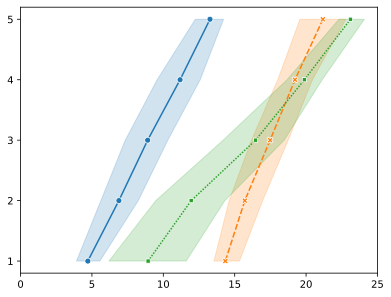

In [9]:
all_data = pd.concat([targeted_df, bfs_df, dfs_df])
ax = sns.lineplot(data=all_data, 
             x="time_infected", y="host_num", hue="experiment_name",
             style="experiment_name", markers=True, dashes=True, legend=False, orient="y")
# Remove x-axis label
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set_xlim(0, 25)
# Set y axis labels as 0, 1, 2, 3, 4
ax.set_yticks([1, 2, 3, 4, 5])

# Save as svg
plt = ax.get_figure()
plt.savefig('./plots/ics_targeted_times.svg', transparent=True)

/home/brian/miniconda3/envs/openstack/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/brian/miniconda3/envs/openstack/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


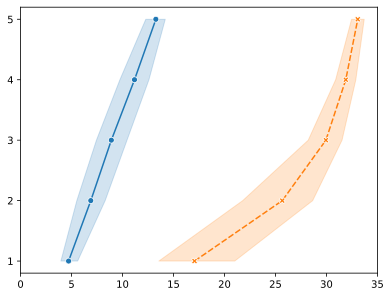

In [6]:
all_data = pd.concat([targeted_df, targeted_ot_df])
ax = sns.lineplot(data=all_data, 
             x="time_infected", y="host_num", hue="experiment_name",
             style="experiment_name", markers=True, dashes=True, legend=False, orient="y")
# Remove x-axis label
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set_xlim(0, 35)
# Set y axis labels as 0, 1, 2, 3, 4
ax.set_yticks([1, 2, 3, 4, 5])

# Save as svg
plt = ax.get_figure()
plt.savefig('./plots/ics_targeted_tricked.svg', transparent=True)

In [7]:
def average_time_to_capture(data: dict[str, ExperimentResult]):
    avg_capture_times = {}
    all_capture_times = {1: [], 2: [], 3: [], 4: [], 5: []}

    for exp_id, result in data.items():
        capture_times = []
        for host in result.hosts_infected:
            if host.name in critical_hosts:
                capture_times.append(host.time_infected / 60)

        # sort the capture times
        capture_times.sort()
        for idx, time in enumerate(capture_times):
            all_capture_times[idx + 1].append(time)

    for host_num, times in all_capture_times.items():
        avg_capture_times[host_num] = mean(times)
    
    return avg_capture_times

In [8]:
bfs_avg = average_time_to_capture(bfs_layered_d10_h50)
dfs_avg = average_time_to_capture(dfs_layered_d10_h50)
targeted_avg = average_time_to_capture(targeted_layered_d10_h50)
targeted_ot_avg = average_time_to_capture(targeted_layeredOT_d10_h50)

print("BFS: ", bfs_avg)
print("DFS: ", dfs_avg)
print("Targeted: ", targeted_avg)
print("Targeted OT: ", targeted_ot_avg)

BFS:  {1: 14.344984712424102, 2: 15.708841353434103, 3: 17.479506181346046, 4: 19.22401781214608, 5: 21.17835574414995}
DFS:  {1: 8.937246444324652, 2: 11.95299213876327, 3: 16.460518286625543, 4: 19.884760196010273, 5: 23.10768012056748}
Targeted:  {1: 4.711330389534986, 2: 6.888844305056113, 3: 8.90292221042845, 4: 11.17413755831895, 5: 13.269269848311389}
Targeted OT:  {1: 17.059886796386152, 2: 25.666028440440144, 3: 29.94482208666978, 4: 31.894291695400522, 5: 33.06847941610548}
